In [224]:
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import numpy as np

In [225]:
# preprocess function prepares data for training

def preprocess(ds, percent):
    x = ds.sample(frac=percent, replace=False)
    data = x
    target = x.pop('quality')
    return ds.drop(x.index), tf.data.Dataset.from_tensor_slices((data.values, target.values)), target 

In [226]:
# load dataset
full_ds = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', delimiter= ';')


In [227]:
### preprocessing ###

full_ds, train_ds, train_target = preprocess(full_ds, 0.8)
full_ds, test_ds, test_target = preprocess(full_ds, 0.5)
full_ds, valid_ds, valid_target = preprocess(full_ds, 1)

In [228]:
def make_binary(target):
    if target >= int(median):
        return 1
    else:
        return 0

def prepare_dataset(ds):
  ds = ds.map(lambda features, target:(features, make_binary(target)))
  ds = ds.map(lambda features, target:(tf.cast(features, dtype=tf.float32), target))
  ds = ds.cache()
  ds = ds.shuffle(32)
  ds = ds.batch(32)
  ds = ds.prefetch(64)
  return ds


In [229]:
train_ds = prepare_dataset(train_ds)
print(train_ds)
valid_ds = prepare_dataset(valid_ds)
print(valid_ds)
test_ds = prepare_dataset(test_ds)
print(test_ds)      

<PrefetchDataset shapes: ((None, 11), (None,)), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: ((None, 11), (None,)), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: ((None, 11), (None,)), types: (tf.float32, tf.int32)>


In [230]:
class WineModel(tf.keras.Model):

    def __init__(self):
        super(WineModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation=tf.nn.sigmoid)
        self.dense2 = tf.keras.layers.Dense(32, activation=tf.nn.sigmoid)
        self.output_layer = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, use_bias=False)

    def call(self, inputs):
        return self.output_layer(self.dense2(self.dense1(inputs)))

In [231]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []
  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  (target == np.round(prediction))
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [232]:
### Testing - BASELINE MODEL with SGD ###

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = WineModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses1 = []
train_accuracies1 = []

test_losses1 = []
test_accuracies1 = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses1.append(test_loss)
test_accuracies1.append(test_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    
    #training (and checking in with training)
    epoch_loss_agg = []
    for input, target in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
  
    #track training loss
    train_losses1.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)

    test_losses1.append(test_loss)
    test_accuracies1.append(test_accuracy)

    print(f' After Epoch: {str(epoch+1)} Test accuracy: {test_accuracies1[epoch]}') 

validation_loss, validation_accuracy = test(model, test_ds, cross_entropy_loss)
print()
print(f'After Training of {str(epoch+1)} Epochs validation accuracy: {validation_accuracy}')

 After Epoch: 1 Test accuracy: 0.55
 After Epoch: 2 Test accuracy: 0.55
 After Epoch: 3 Test accuracy: 0.520703125
 After Epoch: 4 Test accuracy: 0.53125
 After Epoch: 5 Test accuracy: 0.5234375
 After Epoch: 6 Test accuracy: 0.51875
 After Epoch: 7 Test accuracy: 0.515625
 After Epoch: 8 Test accuracy: 0.50703125
 After Epoch: 9 Test accuracy: 0.512109375
 After Epoch: 10 Test accuracy: 0.51484375

After Training of 10 Epochs validation accuracy: 0.510546875


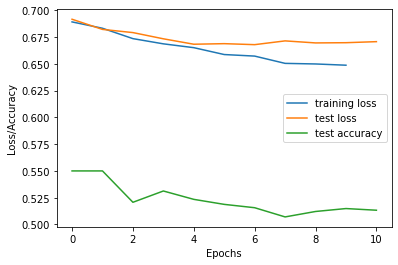

In [233]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses1)
line2, = plt.plot(test_losses1)
line3, = plt.plot(test_accuracies1)
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3),("training loss", "test loss", "test accuracy"))
plt.show()

In [234]:
### Testing - ADAM MODEL ###

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = WineModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses2 = []
train_accuracies2 = []

test_losses2 = []
test_accuracies2 = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses2.append(test_loss)
test_accuracies2.append(test_accuracy)

#check how model performs on train data once before we begin

train_loss, train_accuracy = test(model, train_ds, cross_entropy_loss)
train_losses2.append(train_loss)
train_accuracies2.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    

    #training (and checking in with training)
    epoch_loss_agg = []
    for input, target in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
  
    #track training loss
    train_losses2.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)

    test_losses2.append(test_loss)
    test_accuracies2.append(test_accuracy)

    print(f' After Epoch: {str(epoch+1)} Test accuracy:{test_accuracies2[epoch]}') 

validation_loss, validation_accuracy = test(model, test_ds, cross_entropy_loss)
print()
print(f' After Training of {str(epoch+1)} Epochs validation accuracy:{validation_accuracy}')

 After Epoch: 1 Test accuracy:0.55
 After Epoch: 2 Test accuracy:0.55
 After Epoch: 3 Test accuracy:0.5296875
 After Epoch: 4 Test accuracy:0.541796875
 After Epoch: 5 Test accuracy:0.5265625
 After Epoch: 6 Test accuracy:0.535546875
 After Epoch: 7 Test accuracy:0.55
 After Epoch: 8 Test accuracy:0.519921875
 After Epoch: 9 Test accuracy:0.537890625
 After Epoch: 10 Test accuracy:0.540625

 After Training of 10 Epochs validation accuracy:0.5125


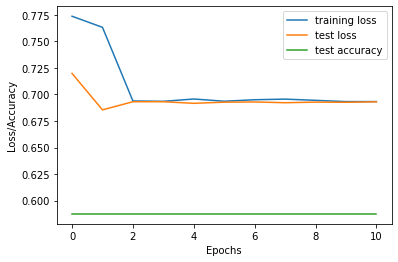

In [235]:
# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3),("training loss", "test loss", "test accuracy"))
plt.show()

In [236]:
### Testing - RMSprop MODEL ###

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = WineModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.RMSprop(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin

train_loss, train_accuracy = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    

    #training (and checking in with training)
    epoch_loss_agg = []
    for input, target in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
  
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f' After Epoch: {str(epoch+1)} Test accuracy is at {test_accuracies[epoch]}') 

validation_loss, validation_accuracy = test(model, test_ds, cross_entropy_loss)
print()
print( f'After Training of {str(epoch+1)} Epochs validation accuracy is at {validation_accuracy}')

 After Epoch: 1 Test accuracy is at 0.55
 After Epoch: 2 Test accuracy is at 0.55
 After Epoch: 3 Test accuracy is at 0.45
 After Epoch: 4 Test accuracy is at 0.55
 After Epoch: 5 Test accuracy is at 0.55
 After Epoch: 6 Test accuracy is at 0.45
 After Epoch: 7 Test accuracy is at 0.55
 After Epoch: 8 Test accuracy is at 0.55
 After Epoch: 9 Test accuracy is at 0.55
 After Epoch: 10 Test accuracy is at 0.55

After Training of 10 Epochs validation accuracy is at 0.55


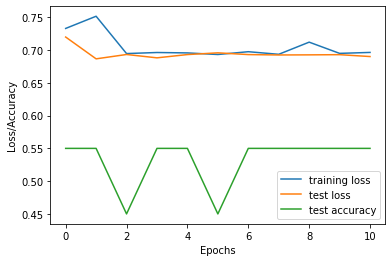

In [237]:
# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3),("training loss", "test loss", "test accuracy"))
plt.show()

In [238]:
### Testing - RMSprop MODEL ###

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = WineModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.RMSprop(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin

train_loss, train_accuracy = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    

    #training (and checking in with training)
    epoch_loss_agg = []
    for input, target in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
  
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f' After Epoch: {str(epoch+1)} Test accuracy is at {test_accuracies[epoch]}') 

validation_loss, validation_accuracy = test(model, test_ds, cross_entropy_loss)
print()
print( f'After Training of {str(epoch+1)} Epochs validation accuracy is at {validation_accuracy}')

 After Epoch: 1 Test accuracy is at 0.55
 After Epoch: 2 Test accuracy is at 0.45
 After Epoch: 3 Test accuracy is at 0.55
 After Epoch: 4 Test accuracy is at 0.55
 After Epoch: 5 Test accuracy is at 0.55
 After Epoch: 6 Test accuracy is at 0.55
 After Epoch: 7 Test accuracy is at 0.55
 After Epoch: 8 Test accuracy is at 0.45
 After Epoch: 9 Test accuracy is at 0.55
 After Epoch: 10 Test accuracy is at 0.55

After Training of 10 Epochs validation accuracy is at 0.55
